In [1]:
import pandas as pd
import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import sys

sys.path.append('../utils')

from text.utils import Book, process_book_content, split_sentences

# Text cleansing

## Search all files inside base path

In [2]:
# Path for books searching
BOOKS_BASE_PATH = '../books/'

#### Organizing books by author

In [3]:
authors = []

for author in glob.glob(os.path.join(BOOKS_BASE_PATH, '*'), ):
    if os.path.isdir(author):
        authors.append(os.path.basename(author))
        print('Author found: {}'.format(authors[len(authors) - 1]))

Author found: Oscar Wilde
Author found: Friedrich Nietzsche
Author found: Ernest Hemingway


In [4]:
total_books = 0
books = []

for author in authors:
    for path in glob.glob(os.path.join(BOOKS_BASE_PATH, author, '*.txt')):
        name = os.path.basename(os.path.splitext(path)[0])
        books.append(Book(name, author, path))
        print('Book added: {}'.format(books[len(books) - 1]))

Book added: Name: The Canterville ghost   Author: Oscar Wilde
Book added: Name: The picture of Dorian Gray   Author: Oscar Wilde
Book added: Name: The antichrist   Author: Friedrich Nietzsche
Book added: Name: Thus spake Zarathustra   Author: Friedrich Nietzsche
Book added: Name: In our time   Author: Ernest Hemingway
Book added: Name: The old man of the sea   Author: Ernest Hemingway


## Defining cleansing functions

License removal was done manually, here only clean books are considered

In [5]:
# Process all books
paragraphs_df = pd.DataFrame(data=[], columns=['Book name', 'Pre processed', 'Post processed', 'Content-length'])

for idx, book in enumerate(books):
    row = [] 
    row.append(book.name)
    row.append(len(book.content))
    book.content = process_book_content(book)
    row.append(len(book.content))
    book.content = ' '.join(book.content)
    row.append(len(book.content))
    paragraphs_df.loc[idx] = row

display(paragraphs_df)

,Book name,Pre processed,Post processed,Content-length
0,The Canterville ghost,108,94,59435
1,The picture of Dorian Gray,1509,1369,375764
2,The antichrist,194,113,122219
3,Thus spake Zarathustra,3688,2959,430060
4,In our time,65,39,14502
5,The old man of the sea,628,576,121161


# Sentences split

In [6]:
for book in books:
    book.content = split_sentences(book.content)

# Statistics calc

In [7]:
dataframe = pd.DataFrame(data=[], columns=['book', 'author', 'num_sentences', 'lengths_sum'])

for idx, book in enumerate(books):
    lengths = [len(sentence) for sentence in book.content]
    dataframe.loc[idx] = [book.name, book.author, len(lengths), np.sum(lengths)]

# Book statistics
book_statistics = dataframe.copy()
book_statistics['mean'] = book_statistics['lengths_sum']  / book_statistics['num_sentences']
    
# Author statistics
author_statistics = dataframe.copy()
author_statistics = author_statistics.groupby('author').agg({'num_sentences': 'sum', 'lengths_sum': 'sum'})
author_statistics['mean'] = author_statistics['lengths_sum']  / author_statistics['num_sentences']

# General statistics
general_statistics = dataframe.copy().drop(['book', 'author'], axis=1)
general_statistics = general_statistics.agg({'num_sentences': 'sum', 'lengths_sum': 'sum'})
general_statistics['mean'] = general_statistics['lengths_sum']  / general_statistics['num_sentences']

display(dataframe)
display(book_statistics)
display(author_statistics)
display(general_statistics.head())
#author_gp = dataframe.groupby('Author')
#author_gp = author_gp.apply(lambda x: x['Total sentences'] * x['Mean'] )
#author_gp.agg({'Total sentences': 'sum' })
#display()

,book,author,num_sentences,lengths_sum
0,The Canterville ghost,Oscar Wilde,404,12045
1,The picture of Dorian Gray,Oscar Wilde,5133,77945
2,The antichrist,Friedrich Nietzsche,940,23149
3,Thus spake Zarathustra,Friedrich Nietzsche,3141,89103
4,In our time,Ernest Hemingway,215,2956
5,The old man of the sea,Ernest Hemingway,1647,25339


,book,author,num_sentences,lengths_sum,mean
0,The Canterville ghost,Oscar Wilde,404,12045,29.8144
1,The picture of Dorian Gray,Oscar Wilde,5133,77945,15.1851
2,The antichrist,Friedrich Nietzsche,940,23149,24.6266
3,Thus spake Zarathustra,Friedrich Nietzsche,3141,89103,28.3677
4,In our time,Ernest Hemingway,215,2956,13.7488
5,The old man of the sea,Ernest Hemingway,1647,25339,15.3849


,num_sentences,lengths_sum,mean
author,,,
Ernest Hemingway,1862,28295,15.196026
Friedrich Nietzsche,4081,112252,27.506003
Oscar Wilde,5537,89990,16.252483


num_sentences     11480.00000
lengths_sum      230537.00000
mean                 20.08162
dtype: float64

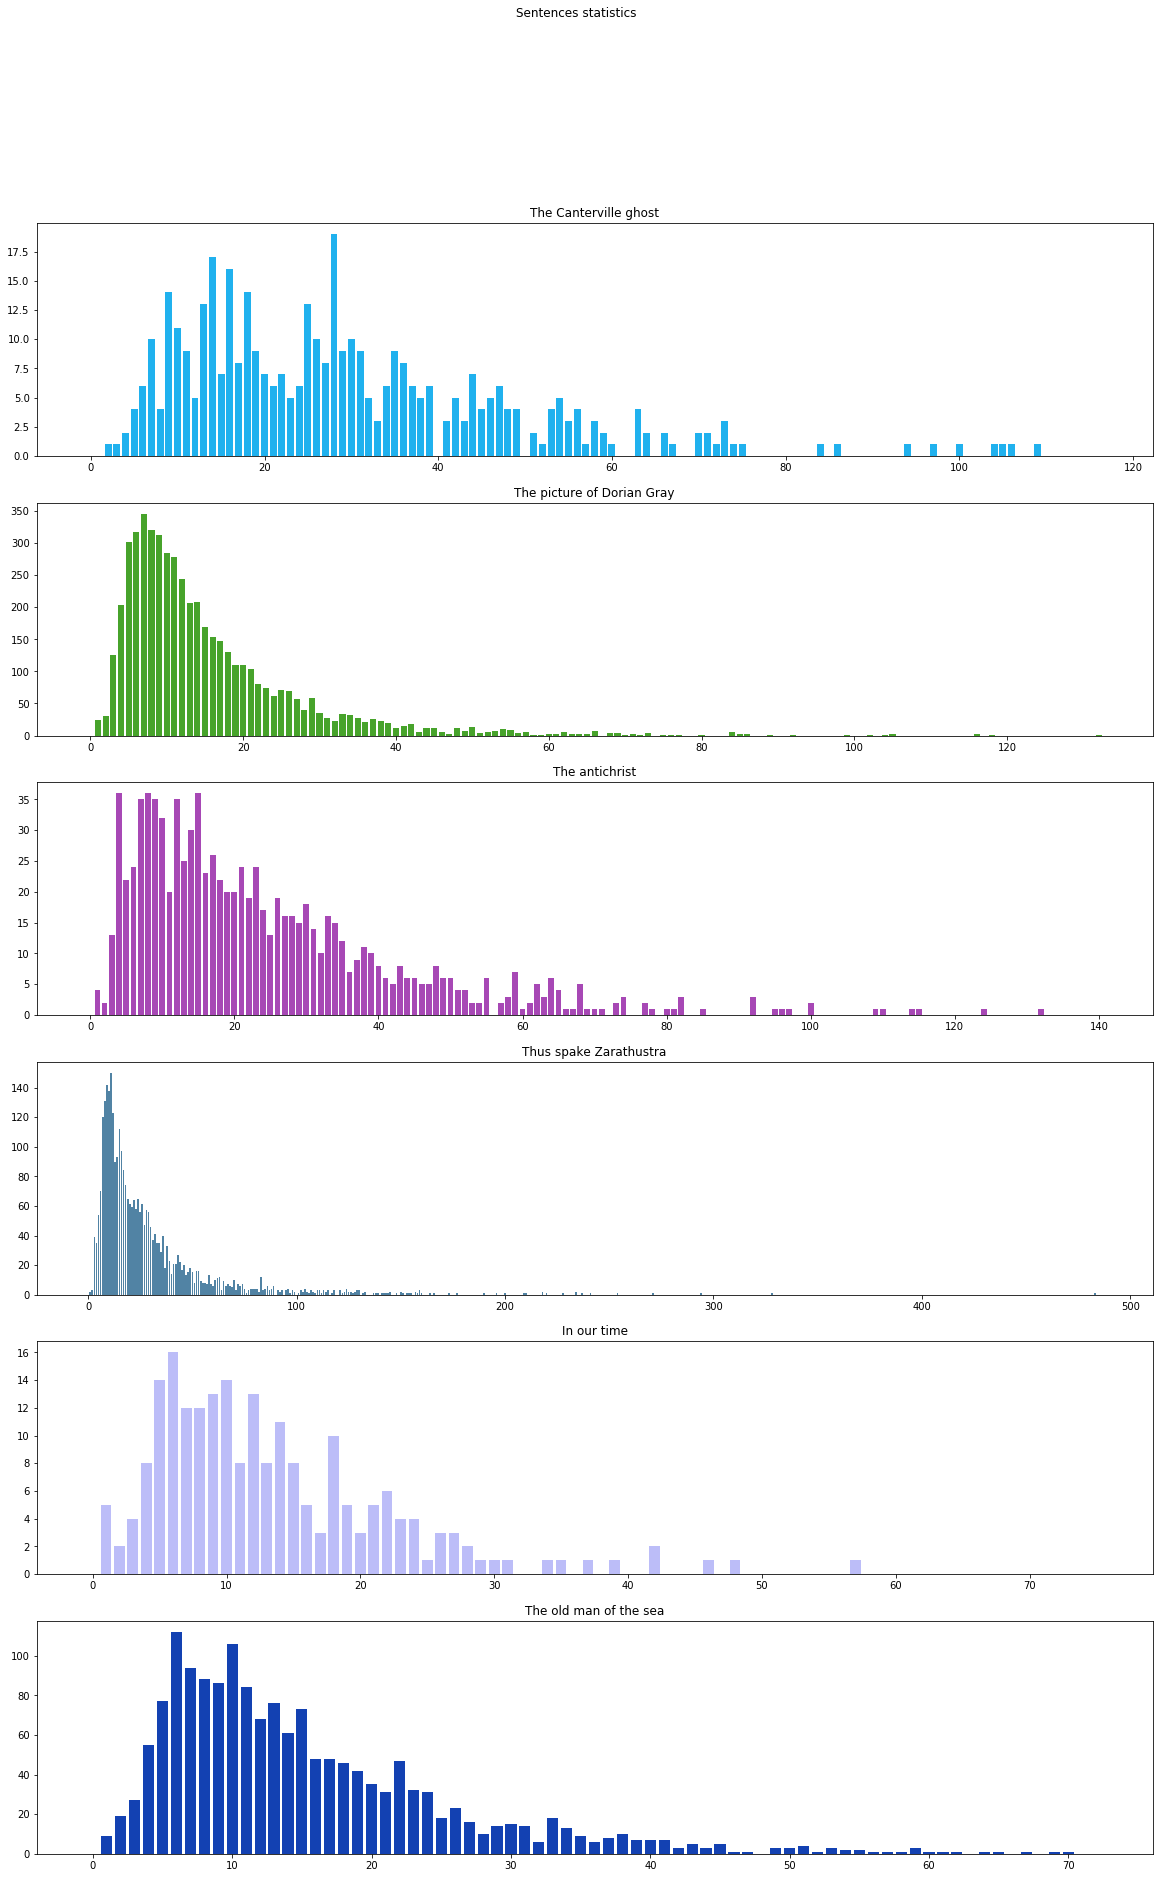

In [8]:
fig, axs = plt.subplots(len(books), figsize=(20, 5 * len(books)))
fig.suptitle('Sentences statistics')

for idx, book in enumerate(books):
    lengths = [len(sentence) for sentence in book.content]
    histogram, bins = np.histogram(lengths, bins=range(np.max(lengths)))
    axs[idx].set_title(book.name)
    axs[idx].bar(bins[:-1], histogram, color=np.random.rand(3,))


# Saving

In [9]:
DATASET_BASE_PATH = '../datasets/'
DATASET_NAME = 'books.pk'

In [10]:
with open(os.path.join(DATASET_BASE_PATH, DATASET_NAME), 'wb') as f:
    pickle.dump(books, f)